## Generative NN based on objective instead of samples

Let $f (x, z) = y  $ be a NN mapping (optional) coordinates $x$ and a noise vector $z$ to the output $y$.
Let $l(y) \in \R_+$ be an objective. 

We want to discover an $f$ such that it generates samples $y$ with $l(y)=0$ or at least minimizes $l(y)$.
In addition, we want the samples to be diverse: different $z$ should produce different $y(x; z)$.

### Experiment 4: harmonic oscillator
We want to to parametrize $\sin$ signals with different phase shifts.

- **Dimensions**: $ n_x = 1, n_y = 1, n_z = 1 $
- **Constraints**:
  - each generated function satisfies the harmonic ODE $y_{xx}(x) + y(x) = 0 \ \forall y\in[0,2\pi] \quad \rightarrow \quad  l(y) = \int_0^{2\pi} (y_{xx}(x) + y(x))^2 dx$
  - each generated function has fixed norm $y^2 (x) + y^2_x (x) = 1 \ \forall y\in[0,2\pi] \quad \rightarrow \quad l(y) = \int_0^{2\pi} ( \sqrt{y^2 (x) + y^2_x (x)} - 1 )^2 dx$
- **Diversity**: repel closest neighour $\delta = $ TODO

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

In [3]:
from torch import nn
from torch.nn.functional import relu
from torch import sin, tanh


class Net(nn.Module):
    def __init__(self, ks):
        super(Net, self).__init__()
        ## Feature-sizes
        self.ks = ks
        ## Fully-connected layers
        self.fcs = nn.ModuleList([nn.Linear(in_features, out_features)
            for in_features, out_features in zip(self.ks[:-1],self.ks[1:])])
        ## Depth
        self.D = len(self.fcs)
    def forward(self, x, z):
        x_ = self.fcs[0](torch.hstack([x, z]))
        for i in range(2,self.D+1):
            x_ = self.fcs[i-1](tanh(x_))
        return x_

In [4]:
nx = 1
ny = 1
nz = 1
model = Net(ks=[nx+nz, 40, 40, ny])

In [5]:
from torch.func import vmap, grad, jacrev, jacfwd, functional_call
params = dict(model.named_parameters())


def f(params, x, z):
    """
    Stateless call to the model.
    That this works for
    * single inputs:
    x: [nx]
    z: [nz]
    returns: [ny]
    -- and -- 
    * batch inputs:
    x: [B, nx]
    z: [B, nz]
    returns: [B, ny]
    """
    return functional_call(model, params, (x, z))


### JACOBIAN ###
## Jacobian wrt x : df/dx
f_x = jacrev(f, argnums=1) ## not for batch!
vf_x = vmap(f_x, in_dims=(None, 0, 0), out_dims=(0)) ## output [B, ny, nx]

### HESSIAN ###
f_xx = jacfwd(f_x, argnums=1) ## not for batch!
vf_xx = vmap(f_xx, in_dims=(None, 0, 0), out_dims=(0)) ## output [B, ny, nx, nx]

# ## Test ##
# B = 5
# xs = torch.rand([B, nx])
# zs = torch.rand([B, nz])

# x, z = xs[0], zs[0]
# y = f(params, x, z)
# print("no batch", x.shape, z.shape, y.shape)

# ys = f(params, xs, zs)
# print("batch", xs.shape, zs.shape, ys.shape)
# ##

ModuleNotFoundError: No module named 'torch.func'

In [5]:
def tensor_product_xz(x, z):
    """
    Generate correct inputs for bx different xs and bz different zs.
    For each z we want to evaluate it at all xs and vice versa, so we need a tensor product between the rows of the two vectors.
    x: [bx, nx]
    z: [bz, nz]
    returns: [bx*bz, nx+nz]
    """
    z_tp = z.repeat_interleave(len(x), 0)
    x_tp = x.repeat(len(z), 1)
    # xz = torch.hstack([x_rep, z_rep])
    return x_tp, z_tp

In [6]:
def adaptive_penalty_update(mu_dict: dict, lambda_dict: dict, nu_dict: dict, sub_loss_unweighted_dict: dict) -> dict:
    gamma = 0.01
    alpha = 0.9
    epsilon = 1.e-08

    with torch.no_grad():
        for key in sub_loss_unweighted_dict.keys():
            nu_dict[key] = nu_dict[key] * alpha + (1-alpha) * sub_loss_unweighted_dict[key]
            mu_dict[key] = gamma / (torch.sqrt(nu_dict[key]) + epsilon)
            lambda_dict[key] = lambda_dict[key] + mu_dict[key] * torch.sqrt(sub_loss_unweighted_dict[key])

    return mu_dict, lambda_dict, nu_dict

In [117]:
## NOTE: currently unused
def compute_diversity(y, use_sum=False, use_similarity=True):
    if use_similarity:
        N_pairs = 2**16
        inds_a = torch.randint(len(y), (N_pairs, ))
        inds_b = torch.randint(len(y), (N_pairs, ))
        mask = inds_a != inds_b
        inds_a = inds_a[mask]
        inds_b = inds_b[mask]
        y_a = y[inds_a]
        y_b = y[inds_b]
        if use_geodesic:=False:
            ## Geodesic distance
            y_an = y_a / y_a.norm(dim=-1).unsqueeze(1)
            y_bn = y_b / y_b.norm(dim=-1).unsqueeze(1)
            inner_products = torch.einsum('bi,bi->b', y_an, y_bn)
            # print(inner_products.min(), inner_products.max())
            eps = 1e-6
            inner_products_filtered = inner_products[torch.logical_and(-1+eps<inner_products, inner_products<1-eps)]
            # inner_products_filtered = inner_products
            # print(inner_products_filtered.min(), inner_products_filtered.max())
            distances_ab = torch.arccos(inner_products_filtered)
        else:
            distances_ab = torch.norm(y_a - y_b, dim=-1, p=2)
        similarities_ab = torch.exp(-10*distances_ab)
        diversity = 1/similarities_ab.mean()        
    else:
        distances = torch.norm(y[:, None] - y, dim=2, p=2)
        if use_sum:
            return ((distances.triu(1)+1e-8).sqrt().mean()).square() ## SUM
        # Create a mask to exclude diagonal elements
        distances = distances.masked_fill(torch.eye(distances.size(0), dtype=torch.bool), float('inf'))
        # Find the minimum distance for each point
        closest_dists = (distances.min(dim=1).values + 1e-8).sqrt()
        diversity = (closest_dists.sqrt()).mean().square()


    return diversity

harmonic: 1.29e-03, amplitude: 1.65e-02, diversity: 0.00: 100%|██████████| 1000/1000 [00:23<00:00, 41.73it/s]


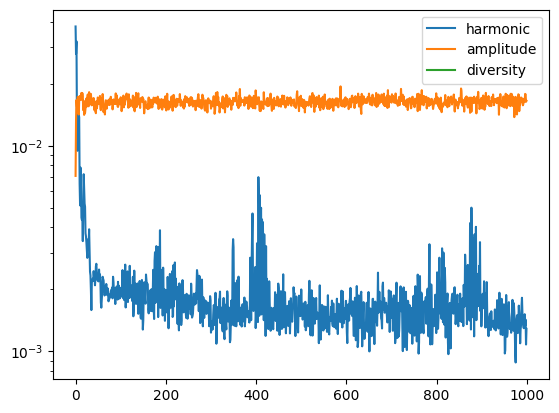

In [90]:
## Losses
loss_keys = ['harmonic', 'amplitude', 'diversity']

## Logging
loss_over_iters = {key: {} for key in loss_keys}


## Diversity budget
# div_min = 0.3
# diversity_is_objective = True

if reinit:=1:
    ## Optimizer
    opt = torch.optim.Adam(model.parameters(), lr=3e-3)

    ## ALM
    mu_dict = {key: torch.tensor(1.) for key in loss_keys}
    nu_dict = {key: torch.tensor(0.) for key in loss_keys}
    lambda_dict = {key: torch.tensor(1.) for key in loss_keys}



## Train
for i in (pbar := trange(1000)):
    opt.zero_grad()

    x = 2*torch.pi*torch.rand(1000, nx) ## sample from [0, 2pi] which is our wavelength
    z = 0.1*torch.randn(5, nz) ## number of latent codes, bz
    # z = torch.zeros(1, nz) ## number of codes, bz
    
    ## HARMONIC ##
    x_tp, z_tp = tensor_product_xz(x, z)
    y = f(params, x_tp, z_tp).squeeze()
    y_xx = vf_xx(params, x_tp, z_tp).squeeze()
    loss_harmonic = (y_xx + y).square().mean()
    
    ## AMPLITUDE ##
    y_x = vf_xx(params, x_tp, z_tp).squeeze()
    loss_amplitude = 0.1*((y.square() + y_x.square()).sqrt() - 1).square().mean()
    
    ## DIVERSITY ##
    diversity = torch.tensor(0.0) ## NOTE: diversity is disabled
    # diversity = compute_diversity(y) * 1e-3
    # if torch.isnan(diversity):
    #     print("nan :(")
    #     break
    # if diversity_is_objective:
    #     loss_diversity = -diversity
    # else:
    #     loss_diversity = torch.max(torch.tensor(0.0), div_min - diversity).square()


    loss_over_iters['harmonic'][i] = loss_harmonic.item()
    loss_over_iters['amplitude'][i] = loss_amplitude.item()
    loss_over_iters['diversity'][i] = diversity.item()

    
    # loss  = lambda_dict['harmonic']*loss_harmonic + .5*mu_dict['harmonic']*loss_harmonic.square()
    # loss += lambda_dict['amplitude']*loss_amplitude + .5*mu_dict['amplitude']*loss_amplitude.square()
    loss  = loss_harmonic #+ .5*mu_dict['harmonic']*loss_harmonic.square()
    loss += loss_amplitude #+ .5*mu_dict['amplitude']*loss_amplitude.square()
    # if diversity_is_objective:
    #     loss += -diversity
    # else:
    #     loss += lambda_dict['diversity']*loss_diversity + .5*mu_dict['diversity']*loss_diversity.square()

    loss.backward()
    opt.step()


    ## ALM
    sub_loss_unweighted_dict = {
        'harmonic': loss_harmonic.detach(), 
        'amplitude': loss_amplitude.detach(),
        'diversity': diversity.detach(),
        }
    mu_dict, lambda_dict, nu_dict = adaptive_penalty_update(mu_dict, lambda_dict, nu_dict, sub_loss_unweighted_dict)


    pbar.set_description(
        f"harmonic: {loss_harmonic.item():.2e}, amplitude: {loss_amplitude.item():.2e}, diversity: {diversity.item():.2f}")


for loss_key in loss_keys:
    plt.plot(list(loss_over_iters[loss_key].keys()), list(loss_over_iters[loss_key].values()), label=loss_key)
plt.semilogy()
plt.legend()
plt.show()

## Plot solution manifold

torch.Size([100, 1]) torch.Size([1, 1])
torch.Size([100, 1]) torch.Size([100, 1])
torch.Size([1, 100]) torch.Size([1, 100])


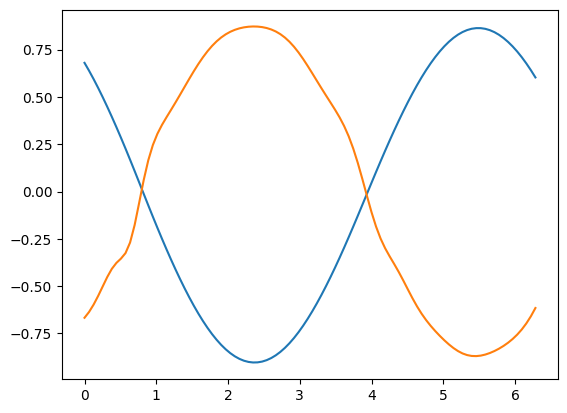

In [116]:
x = torch.linspace(0, 2*torch.pi, 100).unsqueeze(1) ## sample from [0, 2pi] which is our wavelength
# z = torch.zeros(1, nz) ## number of codes, bz
z = 0.1*torch.randn(1, nz) ## number of codes, bz

x_tp, z_tp = tensor_product_xz(x, z)
y = f(params, x_tp, z_tp).squeeze().detach().reshape(len(z), len(x))
y_xx = vf_xx(params, x_tp, z_tp).squeeze().detach().reshape(len(z), len(x))

# print(x.shape, z.shape)
# print(x_tp.shape, z_tp.shape)
# print(y.shape, y_xx.shape)

plt.plot(x, y.T, )
plt.plot(x, y_xx.T, )
plt.sa()